In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sp
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import SparsePCA

In [2]:
def data_setup(level_array, level_type, ref_input, spec_input, heating_data = None):
    # open summed up reference data
    ref_data = xr.open_dataset(ref_input,
                         engine = "netcdf4")

    # Spectral flux data - fluxes per wavenumber
    spec_fluxes = xr.open_mfdataset(spec_input, 
                                    combine = 'nested', concat_dim = 'column',
                                   engine = "netcdf4")
    if (any(level_type == 'h')):
        # monochromatic heating
        heating = heating_data
        heating = heating.transpose("column", "half_level", "wavenumber")

        # heating = xr.open_dataset("/dx02/pc2943/mono_heating.h5", engine = "netcdf4")
        # heating = heating.rename({'mul-586aef02731ae840e3f7c86cffab3ac2':'mono_heating'})

    # set up coordinates/arrays
    wavenumber_coords = spec_fluxes.wavenumber.data

    num_cols = min(len(ref_data.column.data), len(spec_fluxes.column.data))
    
    ref = np.empty((len(level_array), num_cols))
    flux_subset = np.empty((len(level_array), num_cols, len(spec_fluxes.wavenumber.data)))

    for i in range(len(level_array)):
        if (level_type[i] == 'f'):
            if (level_array[i] == 0):
                # TOA outgoing fluxes
                TOA_up_spec = spec_fluxes.spectral_flux_up_lw.isel(half_level = 0).data
                TOA_up_ref = TOA_up_spec.sum(axis = 1)
                ref[i] = TOA_up_ref.compute()

                TOA_up_spec = TOA_up_spec.compute() 
                TOA_up_spec = np.array(TOA_up_spec)
                flux_subset[i] = TOA_up_spec

            elif (level_array[i] == 54):
                # ground downward fluxes
                BOA_dn_spec = spec_fluxes.spectral_flux_dn_lw.isel(half_level = 54).data
                BOA_dn_ref = BOA_dn_spec.sum(axis = 1)
                ref[i] = BOA_dn_ref.compute()

                BOA_dn_spec = BOA_dn_spec.compute()
                BOA_dn_spec = np.array(BOA_dn_spec)
                flux_subset[i] = BOA_dn_spec

            else:
                # net flux in interior levels
                lev_spec = (spec_fluxes.spectral_flux_dn_lw.isel(half_level = level_array[i]).data - 
                            spec_fluxes.spectral_flux_up_lw.isel(half_level = level_array[i]).data)
                flux_subset[i] = lev_spec
                ref[i] = lev_spec.sum(axis = 1)

        elif (level_type[i] == 'h'):
            # interior heating rates
            lev_spec = heating.mono_heating.isel(half_level = level_array[i]).data
            flux_subset[i] = lev_spec
            ref[i] = lev_spec.sum(axis = 1)

        else:
            print("level identifier must be either f(lux) or h(eating rate)")

    # assemble data into xarrays
    ref = xr.DataArray(data = ref, dims = ["half_level", "column"], 
                      coords = dict(half_level=(["half_level"], level_array)))

    flux_subset = xr.DataArray(data = flux_subset, dims = ["half_level", "column", "wavenumber"],
                              coords = dict(half_level=(["half_level"], level_array), 
                                            wavenumber=(["wavenumber"], wavenumber_coords)))

    return flux_subset, ref


In [3]:
def demean_and_normalize(train, test):
    # expects spectral dataset
    mean = train.mean(dim = 'column')
    std = train.std(dim = 'column')
    new_train = (train - mean)/(std**2)
    new_test = (test - mean)/(std**2)
    return new_train, new_test

In [4]:
def abs_rms(estimate, reference):
    # absolute root mean squared error across all ensembles
    # Buehler 2010 eqn 3
    return np.sqrt(((estimate - reference.data)**2).mean(axis = 1))


In [5]:
# load dataset
ref_input = "/data/robertp/CKDMIP_LBL/evaluation1/lw_fluxes/ckdmip_evaluation1_lw_fluxes_present.h5"
spec_input = ["/data/pc2943/spectral_fluxes_1-10.h5", "/data/pc2943/spectral_fluxes_11-20.h5",
                                "/data/pc2943/spectral_fluxes_21-30.h5", "/data/pc2943/spectral_fluxes_31-40.h5",
                                "/data/pc2943/spectral_fluxes_41-50.h5"]
specTest_input = ["/data/pc2943/eval2_spectral_fluxes_1-10.h5", "/data/pc2943/eval2_spectral_fluxes_11-20.h5",
                                "/data/pc2943/eval2_spectral_fluxes_21-30.h5", "/data/pc2943/eval2_spectral_fluxes_31-40.h5",
                                "/data/pc2943/eval2_spectral_fluxes_41-50.h5"]
refTest_input = "/data/robertp/CKDMIP_LBL/evaluation2/lw_fluxes/ckdmip_evaluation2_lw_fluxes-4angle_present.h5"

level_array = np.array([0])
level_type = np.array(['f'])
spec_train, ref_train = data_setup(level_array, level_type, ref_input, spec_input, None)
spec_test, ref_test = data_setup(level_array, level_type, refTest_input, specTest_input, None)


In [6]:
# demean and normalize data for PCA
spec_train, spec_test = demean_and_normalize(spec_train, spec_test)

In [ ]:
# SVD
# P, sigma, S = np.linalg.svd(spec_train[0].T)

Matrix is too large to compute SVD. First solution option: uniformly sample the dataset to reduce the space to about 100,000 predictors (seems like the largest set the computer will handle). 

In [7]:
reduced_spec_train = spec_train[0, :, ::80]
reduced_spec_test = spec_test[0, :, ::80]

In [8]:
#variance in original datast
total_variance_in_x = np.matrix.trace(np.cov(reduced_spec_train.data.T)) # Variance in the original dataset


In [99]:
# SVD
P, sigma, S = np.linalg.svd(reduced_spec_train.data.T)

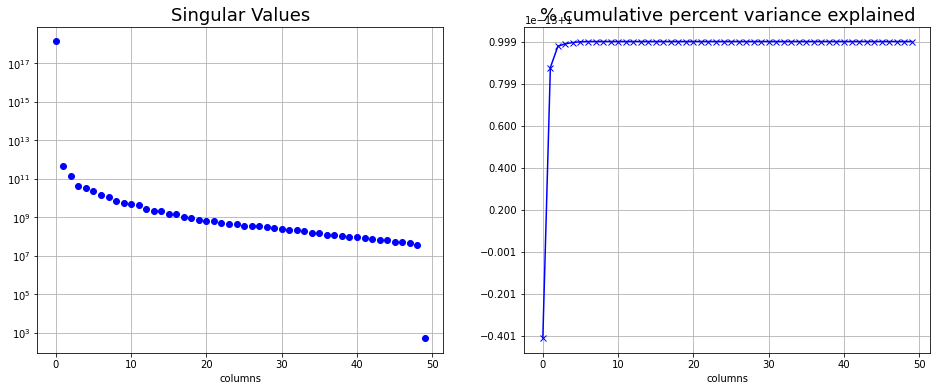

In [102]:
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.semilogy(sigma,'bo')
axes.grid()
axes.set_xlabel('columns')

axes.set_title('Singular Values', fontsize=18)

#and cumulative percent of variance
axes = fig.add_subplot(1, 2, 2)
g = np.cumsum(sigma*sigma)/np.sum(sigma*sigma)
axes.plot(g,'bx-')

axes.set_title('% cumulative percent variance explained', fontsize=18)
axes.set_xlabel('columns')
axes.grid()

plt.show()

In [114]:
### Principal Component Regression
pca = PCA()
model = pca.fit(reduced_spec_train.data.T)
predictor_var = pca.fit_transform(reduced_spec_train.data.T)
test_var = pca.fit_transform(reduced_spec_test.data.T)

In [115]:
val_array = np.arange(1, 50)
test_MSE = np.empty(len(val_array))
train_MSE = np.empty(len(val_array))
var_exp = np.empty(len(val_array))
for i in range(len(val_array)):
    #X = predictor_var[:, :val_array[i]]
    #X_test = test_var[:, :val_array[i]]
    #regression = LinearRegression()
    #regression.fit(X, ref_train.data[0])
    #y_train = regression.predict(X)
    #y_test = regression.predict(X_test)
    #train_MSE[i] = abs_rms(y_train, ref_train.data)
    #test_MSE[i] = abs_rms(y_test, ref_test)
    sigma = model.singular_values_
    var_exp[i] = sigma[0]*sigma[0]/np.sum(sigma[0]*sigma[0])

In [116]:
#plt.semilogy(model.singular_values_)
#sigma = model.singular_values_
#np.cumsum(sigma*sigma)/np.sum(sigma*sigma)

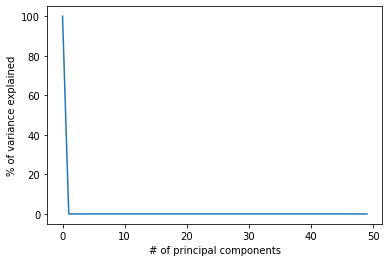

In [119]:
#plt.semilogy(val_array, train_MSE)
#plt.semilogy(val_array, test_MSE)
#plt.ylabel("absolute RMSE")
#plt.xlabel("number of principal components")
#plt.legend(["train", "test"])
#plt.show()

plt.plot(np.arange(len(model.explained_variance_ratio_)), 100 * model.explained_variance_ratio_)
plt.xlabel("# of principal components")
plt.ylabel("% of variance explained")
plt.show()

The built-in PCA function seems to be able to handle the full dataset.

In [59]:
### Principal Component Regression
pca = PCA()
model = pca.fit(spec_train.data[0])
predictor_var = pca.fit_transform(spec_train.data[0])
test_var = pca.fit_transform(spec_test.data[0])

In [60]:
val_array = np.arange(1, 50)
test_MSE = np.empty(len(val_array))
train_MSE = np.empty(len(val_array))
for i in range(len(val_array)):
    X = predictor_var[:, :val_array[i]]
    X_test = test_var[:, :val_array[i]]
    regression = LinearRegression()
    regression.fit(X, ref_train.data[0])
    y_train = regression.predict(X)
    y_test = regression.predict(X_test)
    train_MSE[i] = abs_rms(y_train, ref_train.data)
    test_MSE[i] = abs_rms(y_test, ref_test)

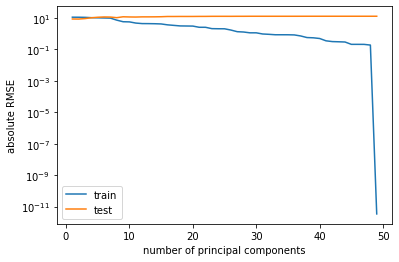

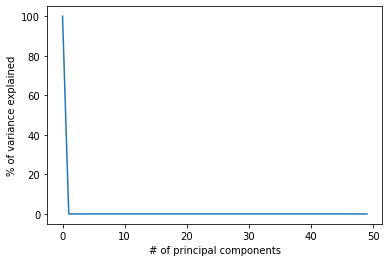

In [61]:
plt.semilogy(val_array, train_MSE)
plt.semilogy(val_array, test_MSE)
plt.ylabel("absolute RMSE")
plt.xlabel("number of principal components")
plt.legend(["train", "test"])
plt.show()

plt.plot(np.arange(len(model.explained_variance_ratio_)), 100 * model.explained_variance_ratio_)
plt.xlabel("# of principal components")
plt.ylabel("% of variance explained")
plt.show()

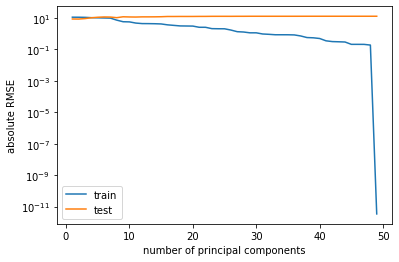

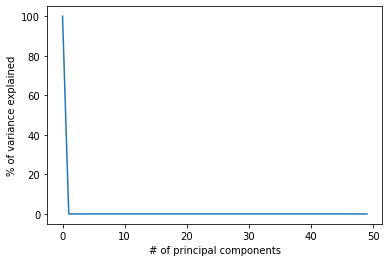

In [62]:
pca = PCA(svd_solver = "full")
model = pca.fit(spec_train.data[0])
predictor_var = pca.fit_transform(spec_train.data[0])
test_var = pca.fit_transform(spec_test.data[0])

val_array = np.arange(1, 50)
test_MSE = np.zeros(len(val_array))
train_MSE = np.zeros(len(val_array))
for i in range(len(val_array)):
    X = predictor_var[:, :val_array[i]]
    X_test = test_var[:, :val_array[i]]
    regression = LinearRegression()
    regression.fit(X, ref_train.data[0])
    y_train = regression.predict(X)
    y_test = regression.predict(X_test)
    train_MSE[i] = abs_rms(y_train, ref_train.data)
    test_MSE[i] = abs_rms(y_test, ref_test)
    
plt.semilogy(val_array, train_MSE)
plt.semilogy(val_array, test_MSE)
plt.ylabel("absolute RMSE")
plt.xlabel("number of principal components")
plt.legend(["train", "test"])
plt.show()

plt.plot(np.arange(len(model.explained_variance_ratio_)), 100 * model.explained_variance_ratio_)
plt.xlabel("# of principal components")
plt.ylabel("% of variance explained")
plt.show()

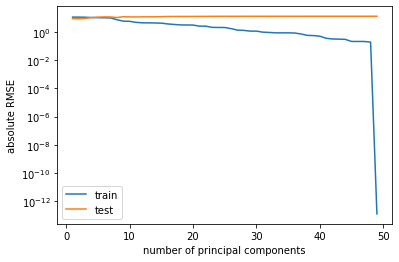

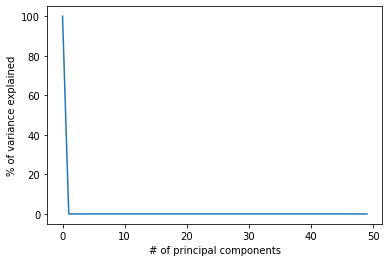

In [63]:
pca = PCA(svd_solver = "randomized")
model = pca.fit(spec_train.data[0])
predictor_var = pca.fit_transform(spec_train.data[0])
test_var = pca.fit_transform(spec_test.data[0])

val_array = np.arange(1, 50)
test_MSE = np.zeros(len(val_array))
train_MSE = np.zeros(len(val_array))
for i in range(len(val_array)):
    X = predictor_var[:, :val_array[i]]
    X_test = test_var[:, :val_array[i]]
    regression = LinearRegression()
    regression.fit(X, ref_train.data[0])
    y_train = regression.predict(X)
    y_test = regression.predict(X_test)
    train_MSE[i] = abs_rms(y_train, ref_train.data)
    test_MSE[i] = abs_rms(y_test, ref_test)
    
plt.semilogy(val_array, train_MSE)
plt.semilogy(val_array, test_MSE)
plt.ylabel("absolute RMSE")
plt.xlabel("number of principal components")
plt.legend(["train", "test"])
plt.show()

plt.plot(np.arange(len(model.explained_variance_ratio_)), 100 * model.explained_variance_ratio_)
plt.xlabel("# of principal components")
plt.ylabel("% of variance explained")
plt.show()

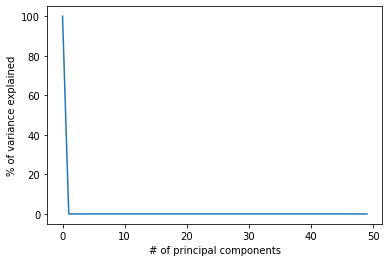

In [64]:
plt.plot(np.arange(len(model.explained_variance_ratio_)), 100 * model.explained_variance_ratio_)
plt.xlabel("# of principal components")
plt.ylabel("% of variance explained")
plt.show()

Now trying to use sparse PCA

train MSE =  [5.15934868]
test MSE =  [13.99351626]


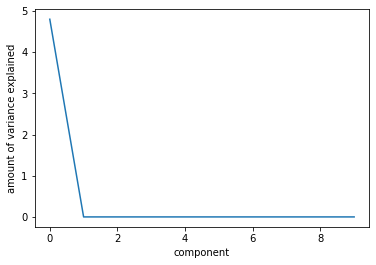

In [66]:
pca = SparsePCA(n_components = 10, n_jobs = -1)
model = pca.fit(reduced_spec_train.data)
predictor_var = pca.fit_transform(reduced_spec_train.data)
test_var = pca.fit_transform(reduced_spec_test.data)

X = predictor_var
X_test = test_var
regression = LinearRegression()
regression.fit(X, ref_train.data[0])
y_train = regression.predict(X)
y_test = regression.predict(X_test)
print("train MSE = ", abs_rms(y_train, ref_train.data))
print("test MSE = ", abs_rms(y_test, ref_test))

p_spca = model.components_.T
qr_decomp = np.linalg.qr(X)
q = qr_decomp[0]
r = qr_decomp[1]
variance = []
for i in range(model.n_components_):
    variance.append(np.square(r[i][i]))

variance = np.array(variance)
norm_v = variance/model.n_components_

#explained_variance_ratio = np.cumsum(variance / total_variance_in_x)
var_explained = norm_v/total_variance_in_x

plt.plot(np.arange(model.n_components_), var_explained)
plt.xlabel("component")
plt.ylabel("amount of variance explained")
plt.show()


train MSE =  [1.42704479]
test MSE =  [465.57232704]


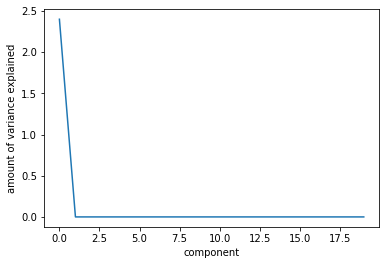

In [67]:
pca = SparsePCA(n_components = 20, n_jobs = -1)
model = pca.fit(reduced_spec_train.data)
predictor_var = pca.fit_transform(reduced_spec_train.data)
test_var = pca.fit_transform(reduced_spec_test.data)

X = predictor_var
X_test = test_var
regression = LinearRegression()
regression.fit(X, ref_train.data[0])
y_train = regression.predict(X)
y_test = regression.predict(X_test)
print("train MSE = ", abs_rms(y_train, ref_train.data))
print("test MSE = ", abs_rms(y_test, ref_test))

p_spca = model.components_.T
qr_decomp = np.linalg.qr(X)
q = qr_decomp[0]
r = qr_decomp[1]
variance = []
for i in range(model.n_components_):
    variance.append(np.square(r[i][i]))

variance = np.array(variance)
norm_v = variance/model.n_components_

#explained_variance_ratio = np.cumsum(variance / total_variance_in_x)
var_explained = norm_v/total_variance_in_x

plt.plot(np.arange(model.n_components_), var_explained)
plt.xlabel("component")
plt.ylabel("amount of variance explained")
plt.show()

train MSE =  [11.30387368]
test MSE =  [8.69619995]


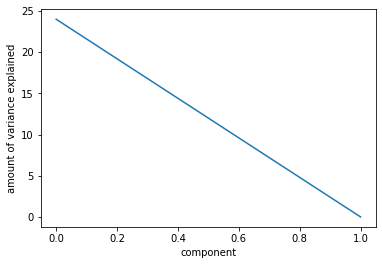

In [68]:
pca = SparsePCA(n_components = 2, n_jobs = -1)
model = pca.fit(reduced_spec_train.data)
predictor_var = pca.fit_transform(reduced_spec_train.data)
test_var = pca.fit_transform(reduced_spec_test.data)

X = predictor_var
X_test = test_var
regression = LinearRegression()
regression.fit(X, ref_train.data[0])
y_train = regression.predict(X)
y_test = regression.predict(X_test)
print("train MSE = ", abs_rms(y_train, ref_train.data))
print("test MSE = ", abs_rms(y_test, ref_test))

p_spca = model.components_.T
qr_decomp = np.linalg.qr(X)
q = qr_decomp[0]
r = qr_decomp[1]
variance = []
for i in range(model.n_components_):
    variance.append(np.square(r[i][i]))

variance = np.array(variance)
norm_v = variance/model.n_components_

#explained_variance_ratio = np.cumsum(variance / total_variance_in_x)
var_explained = norm_v/total_variance_in_x

plt.plot(np.arange(model.n_components_), var_explained)
plt.xlabel("component")
plt.ylabel("amount of variance explained")
plt.show()

Some variance statistics

In [120]:
ref_data = xr.open_dataset(ref_input,
                         engine = "netcdf4")


In [122]:
ref_data

<xarray.Dataset>
Dimensions:                          (band_lw: 13, column: 50, gas: 9, half_level: 55, level: 54)
Dimensions without coordinates: band_lw, column, gas, half_level, level
Data variables:
    pressure_hl                      (column, half_level) float32 ...
    temperature_hl                   (column, half_level) float32 ...
    reference_surface_mole_fraction  (gas) float32 ...
    mole_fraction_fl                 (column, gas, level) float32 ...
    flux_up_lw                       (column, half_level) float32 ...
    flux_dn_lw                       (column, half_level) float32 ...
    band_wavenumber1_lw              (band_lw) float32 ...
    band_wavenumber2_lw              (band_lw) float32 ...
    band_flux_up_lw                  (column, half_level, band_lw) float32 ...
    band_flux_dn_lw                  (column, half_level, band_lw) float32 ...
Attributes:
    title:             Line-by-line longwave fluxes
    history:           Mon Oct 28 10:15:49 2019: ncrcat -O /hugetmp/parr/ckdm...
    project:           CKDMIP
    conventions:       CF-1.7
    constituent_id:    h2o o3 n2 o2 co2 ch4 n2o cfc11 cfc12
    scenario:          present
    software_version:  0.6
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....

In [123]:
ref_data.temperature_hl.isel(half_level = 0)

<xarray.DataArray 'temperature_hl' (column: 50)>
array([185.92947, 193.09258, 198.94635, 181.00346, 190.97432, 196.96121,
       188.04222, 191.75232, 179.87856, 188.42015, 190.97624, 193.61789,
       188.27994, 191.89754, 172.02284, 202.6267 , 176.47684, 192.88834,
       189.6383 , 196.2398 , 200.45363, 180.4991 , 196.20729, 198.20087,
       193.79068, 193.33977, 201.3515 , 205.7095 , 193.44347, 185.44751,
       194.20534, 194.67665, 192.55646, 199.52803, 200.53833, 195.73347,
       215.89856, 190.83202, 185.24017, 178.96057, 205.65851, 180.57632,
       188.11569, 180.30835, 192.04256, 189.20609, 210.91798, 185.88025,
       208.74911, 201.7271 ], dtype=float32)
Dimensions without coordinates: column
Attributes:
    long_name:      Temperature
    units:          K
    standard_name:  air_temperature

In [125]:
np.var(ref_data.temperature_hl.isel(half_level = 0).data)

79.24721

In [129]:
np.var(ref_data.mole_fraction_fl.isel(level = 0).data, axis = 0)

array([2.2815051e-12, 2.8336884e-14, 0.0000000e+00, 8.8817842e-16,
       7.6232965e-21, 0.0000000e+00, 2.0194839e-28, 1.2037062e-35,
       1.0833356e-34], dtype=float32)